In [57]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils
fontsize = 16


sns.set_context("paper", rc={
    "font.size": fontsize,
    "axes.titlesize": fontsize,
    "axes.labelsize": fontsize,
    "xtick.labelsize": fontsize,
    'ytick.labelsize': fontsize,
    'grid.linewidth': 1.5,
})
sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})

plt.rc('font', family='Times New Roman', weight='bold', size=fontsize)
# plt.rc('lines', lw=3.5)
plt.rcParams.update(
    {'font.size': fontsize, "axes.grid": True, 'grid.linestyle': '-.'})


path_mac = "."
path_linux = "."
PATH = utils.get_data_path(path_mac=path_mac, path_linux=path_linux)


### 每一种策略的 执行时间 和 内存用量 受 Dispatch_intervel 的影响

In [58]:
def plot_bar_figure(x, y, title, y_limit, palette, ax, data,
                    x_label='Request Concurrency', y_label="Invocation latency (s)"):

    sns.barplot(x=x, y=y,
                data=data,
                # ci=None
                palette=palette,
                ax=ax
                )
    ax.set_xlabel(x_label, weight="bold")
    ax.set_ylabel(y_label, weight="bold")
    if y_limit:
        ax.set_ylim([0, y_limit])
    # plt.title(title)
    return ax






In [59]:

all_csvs = list(
    map(lambda x: f'{x.split(".csv")[0]}', glob.glob("utilization*.csv")))
strategies = ['BaseBatching', "Kraken", "SFS",  "n_Batching"]
legends = ['BaseBatching', "Kraken", "SFS",  "FaaSBatch"]
strategy_csvs = {
    strategy: list(filter(lambda x: strategy in x, all_csvs)) for strategy in strategies
}

data = pd.DataFrame()
for strategy, csvs in strategy_csvs.items():
    for csv in csvs:
        df = pd.read_csv(f"{csv}.csv")
        dispatch_interval = csv.split("_")[-1]
        df['dispatch_interval'] = dispatch_interval
        if strategy == 'n_Batching':
            df['strategy'] = "FaaSBatch"
        else:
            df['strategy'] = strategy

        # 将每个策略，每个dispatch_intervals下的数据标准化，因为每个实验都是单独测试的
        df["Mem_Util(0.01*MB)"] -= df["Mem_Util(0.01*MB)"].min()
        df["Mem_Util(0.01*MB)"] = 100 * df["Mem_Util(0.01*MB)"] / 1024
        df["CPU_Util(%)"] -= df["CPU_Util(%)"].min()
        data = pd.concat([df, data])


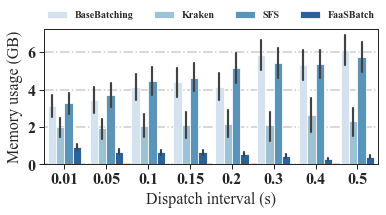

In [61]:

fig, ax1 = plt.subplots(figsize=(6, 2.5))
sns.barplot(x="dispatch_interval", y="Mem_Util(0.01*MB)", hue="strategy", hue_order=legends,
            data=data, palette="Blues", order=sorted(data['dispatch_interval'].unique()))
data['strategy'].unique()
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1),
                ncol=4, title=None, frameon=False, fontsize=fontsize-6)
ax1.set_ylabel("Memory usage (GB)")
ax1.set_xlabel("Dispatch interval (s)")
fig.show()

其他策略需要把资源和时间花在构建冗余的S3 client对象上


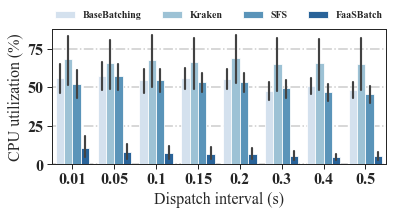

In [62]:
print("其他策略需要把资源和时间花在构建冗余的S3 client对象上")
fig, ax1 = plt.subplots(figsize=(6, 2.5))
sns.barplot(x="dispatch_interval", y="CPU_Util(%)", hue="strategy", hue_order=legends,
            data=data, palette="Blues", order=sorted(data['dispatch_interval'].unique()))
data['strategy'].unique()
sns.move_legend(ax1, "lower center", bbox_to_anchor=(.5, 1),
                ncol=4, title=None, frameon=False, fontsize=fontsize-6)
ax1.set_ylabel("CPU utilization (%)")
ax1.set_xlabel("Dispatch interval (s)")
fig.show()